In [1]:
!git clone https://github.com/sunnynevarekar/image-classification-recipe.git

Cloning into 'image-classification-recipe'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 9), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
!pip install git+https://github.com/microsoft/ComputerVision.git@master#egg=utils_cv

  Cloning https://github.com/microsoft/ComputerVision.git (to revision master) to /tmp/pip-install-8ocpuzrs/utils-cv
  Running command git clone -q https://github.com/microsoft/ComputerVision.git /tmp/pip-install-8ocpuzrs/utils-cv
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 215kB 7.9MB/s 
     |████████████████████████████████| 4.7MB 9.6MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 2.0MB 48.3MB/s 
     |████████████████████████████████| 14.1MB 159kB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 163kB 55.9MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 307kB 50.2MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
     |██████████████████████

In [1]:
%cd image-classification-recipe

/content/image-classification-recipe


In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
from torchvision import transforms as T
from datasets import ImageClassificationDataset, load_annotations_from_folder, split_data
from callbacks import TrainMetricRecorder
from engine import fit, get_predictions
import viz_utils

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.classification.plot import plot_pr_roc_curves
from utils_cv.classification.widget import ResultsWidget
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url

In [4]:
#get dataset
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)

path = Path(DATA_PATH)
path.ls() 

[PosixPath('/usr/local/lib/python3.6/dist-packages/data/fridgeObjects/carton'),
 PosixPath('/usr/local/lib/python3.6/dist-packages/data/fridgeObjects/water_bottle'),
 PosixPath('/usr/local/lib/python3.6/dist-packages/data/fridgeObjects/milk_bottle'),
 PosixPath('/usr/local/lib/python3.6/dist-packages/data/fridgeObjects/can')]

In [5]:
#parameters
IMAGE_SIZE = 300
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4
RANDOM_STATE = 19

In [6]:
#create dataset and dataloader for train and validation set
#load annotations
image_ids, labels, class_names = load_annotations_from_folder(DATA_PATH)
assert len(image_ids) == len(labels)
print(f'Total images: {len(image_ids)}')
print(f'Classes: {class_names}')

#split data into train and validation set
train_img_ids, val_img_ids, train_labels, val_labels = split_data(image_ids, labels, test_size=0.2, 
                                                                    shuffle=True, stratify=labels, random_state=RANDOM_STATE)

assert len(train_img_ids) == len(train_labels)
assert len(val_img_ids) == len(val_labels)

print(f'Train samples: {len(train_img_ids)}')
print(f'Validation samples: {len(val_img_ids)}')


#calculate and display number of samples per class in train and test set
print()
print('Class distribution:')
print()
print('Train set:')
train_classes, train_counts = np.unique(train_labels, return_counts=True)
assert len(train_classes) == len(class_names)
viz_utils.print_table(class_names, train_counts, header=['class', 'count'])
print()
print('validation set:') 
val_classes, val_counts = np.unique(val_labels, return_counts=True)
assert len(val_classes) == len(class_names)
viz_utils.print_table(class_names, val_counts, header=['class', 'count'])

Total images: 134
Classes: ['can', 'carton', 'milk_bottle', 'water_bottle']
Train samples: 107
Validation samples: 27

Class distribution:

Train set:
class               count               
can                 26.0000             
carton              26.0000             
milk_bottle         29.0000             
water_bottle        26.0000             

validation set:
class               count               
can                 6.0000              
carton              6.0000              
milk_bottle         8.0000              
water_bottle        7.0000              


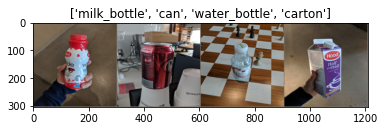

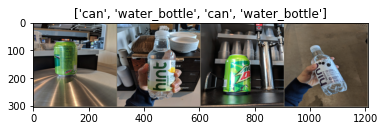

In [7]:
#define transformations for train and validation set
#imagenet stats
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
train_transforms = T.Compose([T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)), T.ToTensor(), T.Normalize(mean, std)])
val_transforms = T.Compose([T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)), T.ToTensor(), T.Normalize(mean, std)])

#create train and validation dataset
train_dataset = ImageClassificationDataset(str(path), train_img_ids, train_labels, train_transforms)
val_dataset = ImageClassificationDataset(str(path), val_img_ids, val_labels, val_transforms)

#create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader =  torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#show images
batch_inputs, batch_labels = next(iter(train_loader))
out = torchvision.utils.make_grid(batch_inputs[:4])
viz_utils.imshow(out, mean, std, title=[class_names[x] for x in batch_labels[:4]])

batch_inputs, batch_labels = next(iter(val_loader))
out = torchvision.utils.make_grid(batch_inputs[:4])
viz_utils.imshow(out, mean, std, title=[class_names[x] for x in batch_labels[:4]])

In [8]:
#create model
model = torchvision.models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, len(class_names))   

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [9]:
#select gpu device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#move model to right device
model.to(device)

#create loss criterion
criterion = torch.nn.CrossEntropyLoss()

#create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#create recorder to record metrics during training
recorder = TrainMetricRecorder(['accuracy', 'precision', 'recall', 'f1_score'])

In [10]:
print("Training:")
   
fit(model, train_loader, val_loader, optimizer, criterion, EPOCHS, device, recorder)

history = recorder.history

header = ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']

viz_utils.print_table(history[header[0]], history[header[1]], history[header[2]], history[header[3]], header=header)

  0%|          | 0/7 [00:00<?, ?it/s]

Training:


  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 1: train_loss: 1.3032 val_loss:  0.8862



  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 2: train_loss: 0.3377 val_loss:  0.5111



  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 3: train_loss: 0.0956 val_loss:  0.3055



  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 4: train_loss: 0.0550 val_loss:  0.2195



  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 5: train_loss: 0.0314 val_loss:  0.2017



  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 6: train_loss: 0.0244 val_loss:  0.2152



  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 7: train_loss: 0.0223 val_loss:  0.1914



  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 8: train_loss: 0.0136 val_loss:  0.2009



  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 9: train_loss: 0.0107 val_loss:  0.1938



100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


Epoch 10: train_loss: 0.0081 val_loss:  0.1812

train_loss          val_loss            train_accuracy      val_accuracy        
1.3032              0.8862              0.3925              0.7778              
0.3377              0.5111              0.9907              0.7778              
0.0956              0.3055              1.0000              0.9259              
0.0550              0.2195              1.0000              0.9259              
0.0314              0.2017              1.0000              0.9259              
0.0244              0.2152              1.0000              0.9259              
0.0223              0.1914              1.0000              0.9630              
0.0136              0.2009              1.0000              0.9630              
0.0107              0.1938              1.0000              0.9630              
0.0081              0.1812              1.0000              0.9630              


In [ ]:
#get predictions and probabilitis for validation data
preds, probs = get_predictions(model, val_loader, device)

100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


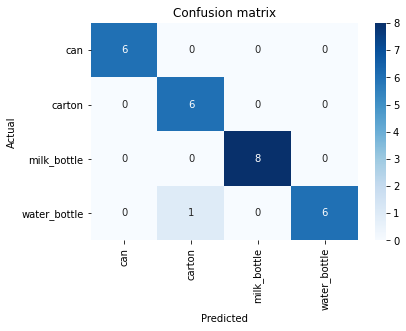

In [12]:
from sklearn.metrics import confusion_matrix
viz_utils.plot_confusion_matrix(confusion_matrix(val_labels, preds), labels=class_names)